## **Twitter Sentiment Analysis** 
## **Usecase: PiggyVest**

### Overview
This notebook is designed to extract and analyze the sentiment expressed in tweets about PiggyVest using Natural Language Processing (NLP) techniques. The analysis is carried out using NLTK's inbuilt VADER model, which is well-suited for processing and interpreting sentiments in social media texts. The notebook is structured as follows:
1. Data Import and Initial Inspection
2. Data Cleaning and Preprocessing
3. Sentiment Analysis
4. EDA

## **DATA IMPORT AND INITIAL INSPECTION**
Let's start by collecting our data from the Snowflake warehouse, then understanding the structure and size of the dataset. We'll look at the first few rows and check the dimensions to get an idea of what we're working with.

In [37]:
# import librabries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import snowflake.connector
import getpass
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [38]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
# Prompt for to enter secrets securely
user = getpass.getpass(prompt='Enter your Snowflake username: ')
password = getpass.getpass(prompt='Enter your Snowflake password: ')

In [ ]:
# Establish the connection using the masked password
ctx = snowflake.connector.connect(
    user=user,
    password=password,
    account='hi37226.eu-north-1.aws',
    warehouse='sentiment_warehouse',
    database='sentiment_database',
    schema='sentiment_schema'
)

In [ ]:
# Create a cursor object
cur = ctx.cursor()

In [ ]:
# Execute a query
cur.execute("SELECT * FROM sentiment_database.sentiment_schema.dim_tweets")

In [ ]:
tweets = cur.fetch_pandas_all()
print(tweets)

In [39]:
tweets = pd.read_csv(r"C:\Users\HP\Documents\projects\Sentiment Analysis\2024-08-11 4_06pm.csv")
data = tweets.copy()

In [40]:
data.head()

,TWEET_ID,USER_ID,CREATED_AT,TEXT,URL,MENTIONS,LANG,FAVOURITES,RETWEETS,REPLIES,QUOTES,VIEW_COUNT,HASHTAGS
0,1819681803604508810,886083200,2024-08-03 10:28:44.000 Z,Piggyvest is a life saver. I'm introducing thi...,NaN,NaN,en,7,2,5,0,1715.0,NaN
1,1819477474595545568,1761141472781279232,2024-08-02 20:56:48.000 Z,PiggyVest go think say I don die,https://t.co/rME1dNHNjK,NaN,en,3,0,1,0,47.0,NaN
2,1819379501471535188,1249897379207286784,2024-08-02 14:27:30.000 Z,Use piggyvest bros,NaN,NaN,lt,1,0,1,1,14263.0,NaN
3,1819764467078508980,1759572460301672448,2024-08-03 15:57:13.000 Z,Piggyvest needs to stop me from withdrawing,NaN,NaN,en,1,0,1,0,66.0,NaN
4,1819440896863281310,1081875638573809664,2024-08-02 18:31:28.000 Z,My female friend sent me a screenshot of her s...,NaN,NaN,en,56,22,10,0,2969.0,NaN


In [41]:
data.shape

(1332, 13)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TWEET_ID    1332 non-null   int64  
 1   USER_ID     1332 non-null   int64  
 2   CREATED_AT  1332 non-null   object 
 3   TEXT        1332 non-null   object 
 4   URL         578 non-null    object 
 5   MENTIONS    206 non-null    object 
 6   LANG        1332 non-null   object 
 7   FAVOURITES  1332 non-null   int64  
 8   RETWEETS    1332 non-null   int64  
 9   REPLIES     1332 non-null   int64  
 10  QUOTES      1332 non-null   int64  
 11  VIEW_COUNT  782 non-null    float64
 12  HASHTAGS    157 non-null    object 
dtypes: float64(1), int64(6), object(6)
memory usage: 135.4+ KB


## **DATA CLEANING AND PREPROCESSING**
The columns with missing values will not be used within the scope of this notebook. In that case, we would not be handling the missing values

In [43]:
data.columns = data.columns.str.strip().str.lower()
data.columns

Index(['tweet_id', 'user_id', 'created_at', 'text', 'url', 'mentions', 'lang',
       'favourites', 'retweets', 'replies', 'quotes', 'view_count',
       'hashtags'],
      dtype='object')

The `created_at` column is changed from object to datatetime datatype

In [44]:
data['date_created'] = pd.to_datetime(data['created_at'])
data.drop(columns='created_at', inplace=True)

A `wordcount` column is created, and wordcounts < 2 will be dropped

In [45]:
data['wordcount'] = data.text.apply(lambda x: len(x.split(' ')))
data = data[data['wordcount'] >= 2].reset_index(drop=True)

In [46]:
print('Dataset shape:', data.shape)
print(data.columns)

Dataset shape: (1319, 14)
Index(['tweet_id', 'user_id', 'text', 'url', 'mentions', 'lang', 'favourites',
       'retweets', 'replies', 'quotes', 'view_count', 'hashtags',
       'date_created', 'wordcount'],
      dtype='object')


In [47]:
def preprocess(text):
    """
    Preprocesses the input text by removing special characters, stopwords and changes the characters  to lower case.
    
    Parameters:
    text (str): The raw tweet text.

    Returns:
    str: The cleaned, preprocessed text without punctuation nor stopwords.
    """
    lemmatizer = WordNetLemmatizer()
    preprocessed_text = []
    doc = nlp(text) 
    for i in doc:
        if i.is_punct:
            continue
        i = i.lemma_.lower()
        if i in stopwords.words('english'):
            continue
        preprocessed_text.append(i.lower())
        
    return ' '.join(preprocessed_text)


In [48]:
data['processed_text'] = data['text'].apply(preprocess)

In [49]:
data.head()

,tweet_id,user_id,text,url,mentions,lang,favourites,retweets,replies,quotes,view_count,hashtags,date_created,wordcount,processed_text
0,1819681803604508810,886083200,Piggyvest is a life saver. I'm introducing thi...,NaN,NaN,en,7,2,5,0,1715.0,NaN,2024-08-03 10:28:44+00:00,11,piggyvest life saver introduce friend
1,1819477474595545568,1761141472781279232,PiggyVest go think say I don die,https://t.co/rME1dNHNjK,NaN,en,3,0,1,0,47.0,NaN,2024-08-02 20:56:48+00:00,8,piggyvest go think say die
2,1819379501471535188,1249897379207286784,Use piggyvest bros,NaN,NaN,lt,1,0,1,1,14263.0,NaN,2024-08-02 14:27:30+00:00,3,use piggyvest bro
3,1819764467078508980,1759572460301672448,Piggyvest needs to stop me from withdrawing,NaN,NaN,en,1,0,1,0,66.0,NaN,2024-08-03 15:57:13+00:00,7,piggyvest need stop withdraw
4,1819440896863281310,1081875638573809664,My female friend sent me a screenshot of her s...,NaN,NaN,en,56,22,10,0,2969.0,NaN,2024-08-02 18:31:28+00:00,52,female friend send screenshot saving jollof ...


## **SENTIMENT ANALYSIS**
We will use a NLTK's inbuilt SentimentAnalyzer model to classify the sentiment of each tweet. The model is fine-tuned for sentiment analysis and will return an array of probabilities representing `negative`, `neutral`, `positive` and `compound`. The scores returned by VADER `compound` range from -1 to 1, -1 being very negative and one being very positive.

#### Sentiment on `processed_text` without stopwords

In [50]:
sentiment = SentimentIntensityAnalyzer()

data['sentiment_score'] = data.processed_text.apply(lambda x: sentiment.polarity_scores(x)['compound'])

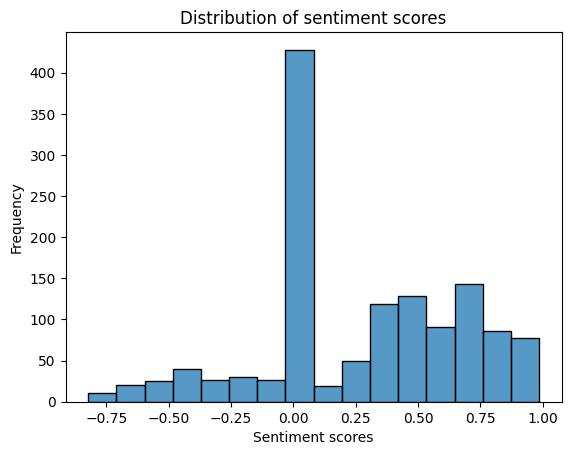

In [51]:
sns.histplot(data['sentiment_score'])
plt.title('Distribution of sentiment scores')
plt.ylabel('Frequency')
plt.xlabel('Sentiment scores')
plt.show()

In [52]:
data['sentiment_score'].describe()

count    1319.000000
mean        0.263923
std         0.403362
min        -0.822500
25%         0.000000
50%         0.278200
75%         0.624900
max         0.985500
Name: sentiment_score, dtype: float64

(Pawan, 2020) in his work [https://www.kaggle.com/pawanbhandarkar/training-a-sith-lord] compared different split points for the data to identify the best way to split the output of Vader into Negative, Positive and Neutral Categories. This was performed on the US Airline Twitter Dataset but it is expected to be similarly applicable to other Twitter datasets as well.

Best Thresholds for splitting Vader tweet sentiments:

> sentiment['compound'] < -0.05 => Negative
>
> sentiment['compound'] > 0.35 => Positive
>
> -0.05 Neutral < sentiment['compound'] < 0.35 => Neutral

In [53]:
def sentiment_analyzer(compound_score):
    """
    Classify sentiment based on a compound score.

    Parameters
    ----------
    compound_score : float
        The compound sentiment score to classify.

    Returns
    -------
    str
        The sentiment label.
    """

    if compound_score >= 0.35:
        return 'positive'
    
    elif compound_score <= -0.05:
        return 'negative'
    
    else:
        return 'neutral'


In [54]:
data['sentiments'] = data['sentiment_score'].apply(sentiment_analyzer)
data['sentiments'].value_counts()

positive    604
neutral     538
negative    177
Name: sentiments, dtype: int64

In [55]:
positive = data[data['sentiments'] == 'positive']
negative = data[data['sentiments'] == 'negative']
neutral = data[data['sentiments'] == 'neutral']

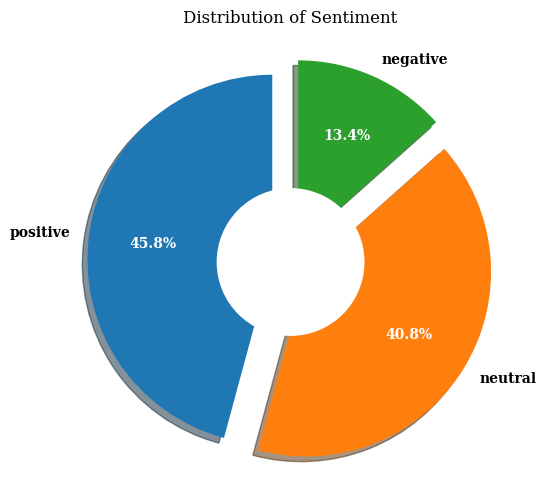

In [56]:
label_data = data['sentiments'].value_counts()
explode = (0.1, 0.1, 0.1)
plt.figure(figsize=(8, 6))
patches, texts, pcts = plt.pie(label_data,labels = label_data.index,pctdistance = 0.65,shadow = True,startangle = 90,explode = explode,
                               autopct = '%1.1f%%',textprops={ 'fontsize': 10,'color': 'black','weight': 'bold','family': 'serif' })
plt.setp(pcts, color='white')
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=10, **hfont)
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Distribution of Sentiment')
plt.show()

In [57]:
data.head()

,tweet_id,user_id,text,url,mentions,lang,favourites,retweets,replies,quotes,view_count,hashtags,date_created,wordcount,processed_text,sentiment_score,sentiments
0,1819681803604508810,886083200,Piggyvest is a life saver. I'm introducing thi...,NaN,NaN,en,7,2,5,0,1715.0,NaN,2024-08-03 10:28:44+00:00,11,piggyvest life saver introduce friend,0.4939,positive
1,1819477474595545568,1761141472781279232,PiggyVest go think say I don die,https://t.co/rME1dNHNjK,NaN,en,3,0,1,0,47.0,NaN,2024-08-02 20:56:48+00:00,8,piggyvest go think say die,-0.5994,negative
2,1819379501471535188,1249897379207286784,Use piggyvest bros,NaN,NaN,lt,1,0,1,1,14263.0,NaN,2024-08-02 14:27:30+00:00,3,use piggyvest bro,0.0000,neutral
3,1819764467078508980,1759572460301672448,Piggyvest needs to stop me from withdrawing,NaN,NaN,en,1,0,1,0,66.0,NaN,2024-08-03 15:57:13+00:00,7,piggyvest need stop withdraw,-0.2960,negative
4,1819440896863281310,1081875638573809664,My female friend sent me a screenshot of her s...,NaN,NaN,en,56,22,10,0,2969.0,NaN,2024-08-02 18:31:28+00:00,52,female friend send screenshot saving jollof ...,0.6705,positive


## **EDA**

#### Analyzing the frequency of specific keywords

In [58]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [59]:
def most_common_chart(dataframe, title):
	corpus = ' '.join([i for i in dataframe.processed_text.values])
	tokenized_word = word_tokenize(corpus)
	count = FreqDist(tokenized_word)
	most_common = count.most_common(10)

	plt.figure(figsize=(10, 6))
	ax = sns.barplot(x=[word[1] for word in most_common], y=[word[0] for word in most_common])
	ax.bar_label(ax.containers[0], fmt='%.0f', label_type='edge')
	plt.xlabel('Frequency')
	plt.ylabel('Word')
	plt.title(title)
	print(most_common)
	plt.show()

[('piggyvest', 1265), ('money', 213), ('save', 204), ('use', 156), ('saving', 134), ('get', 131), ('go', 122), ('like', 105), ('dey', 90), ('see', 88)]


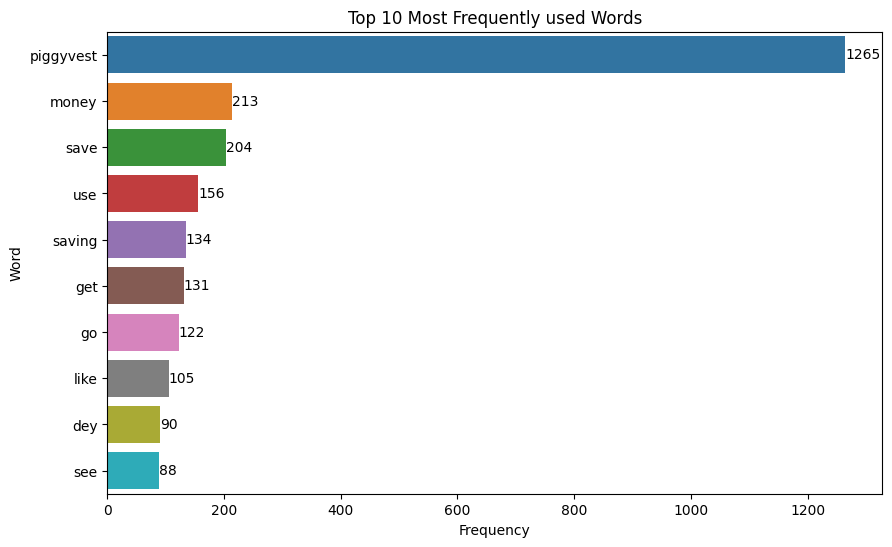

In [60]:
most_common_chart(data, 'Top 10 Most Frequently used Words')

[('piggyvest', 590), ('save', 195), ('money', 108), ('use', 104), ('like', 95), ('saving', 94), ('get', 86), ('start', 73), ('interest', 62), ('amp', 62)]


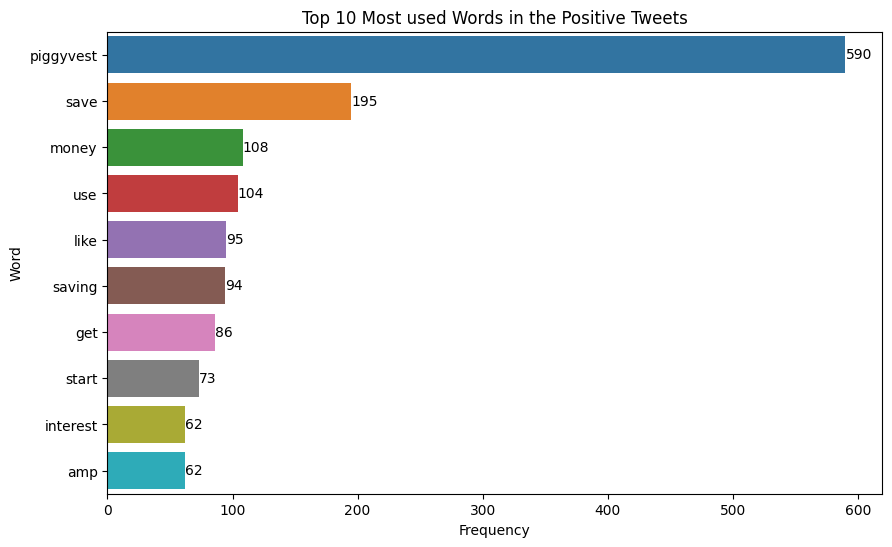

In [61]:
most_common_chart(positive, 'Top 10 Most used Words in the Positive Tweets')

[('piggyvest', 169), ('money', 32), ('go', 31), ('mr', 20), ('ibu', 19), ('broke', 17), ('sportybet', 17), ('asisat', 14), ('oshoala', 14), ('use', 13)]


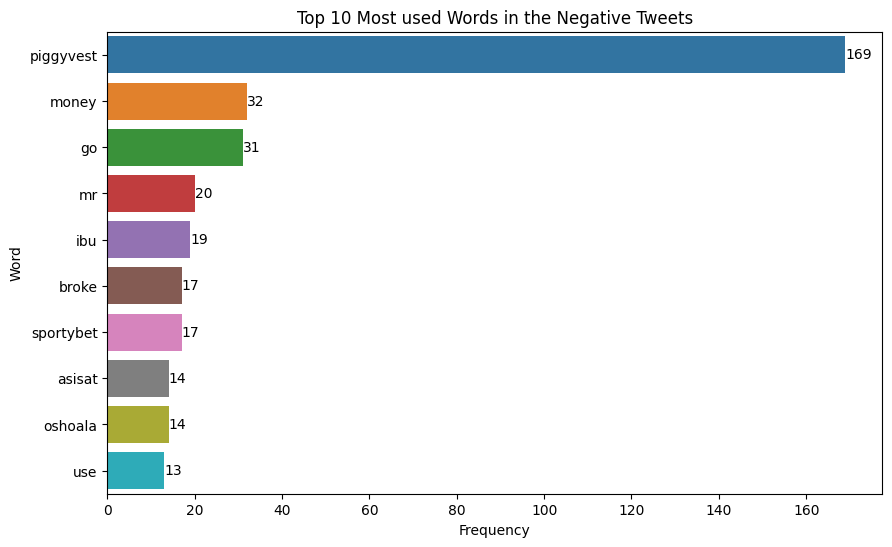

In [62]:
most_common_chart(negative, 'Top 10 Most used Words in the Negative Tweets')

#### Topic Modeling
Implementing the topic modeling technique, **Latent Dirichlet Allocation (LDA)** to identify underlying topics or themes in the feedback data. This can provide deeper insights into the content and help analyze sentiment within specific topics.

In [63]:
# Create a CountVectorizer
vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english', ngram_range=(1, 2))

# Apply CountVectorizer to the processed feedback text
dtm = vectorizer.fit_transform(data['processed_text'])

# Perform LDA topic modeling
num_topics = 10  # Specify the desired number of topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()
top_words = 10  # Specify the number of top words to retrieve for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

Topic 0:
piggyvest dey na account save money piggyvest dey wey person piggyvest account

Topic 1:
piggyvest cowrywise money open bank piggyvest cowrywise open piggyvest cowrywise piggyvest year saving

Topic 2:
piggyvest day today user break buy ask saving 000 add

Topic 3:
piggyvest save money like app year know use account withdraw

Topic 4:
piggyvest use use piggyvest link save start 000 amp saving invest

Topic 5:
piggyvest opay zenith tinubu lagos kuda believe naira abuja send

Topic 6:
piggyvest today make davido love good way toyin abraham abraham toyin

Topic 7:
mr mr ibu ibu piggyvest happie sportybet boys larry happie boys broke

Topic 8:
piggyvest saving dollar cofounder people say think rate naira thank

Topic 9:
piggyvest money use piggyv save send join lock month end



<AxesSubplot:xlabel='sentiments', ylabel='wordcount'>

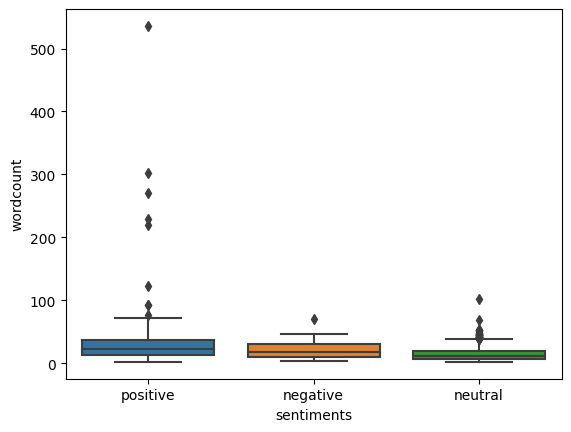

In [64]:
sns.boxplot(data=data, x='sentiments', y='wordcount')

On an average, tweets with positive sentiment have more word counts compared to the other classes

In [83]:
tweets_by_month = data.groupby(data['date_created'].dt.to_period('M')).count()

positive_tweets_by_month = positive.groupby(positive['date_created'].dt.to_period('M')).count()
negative_tweets_by_month = negative.groupby(negative['date_created'].dt.to_period('M')).count()
neutral_tweets_by_month = neutral.groupby(neutral['date_created'].dt.to_period('M')).count()

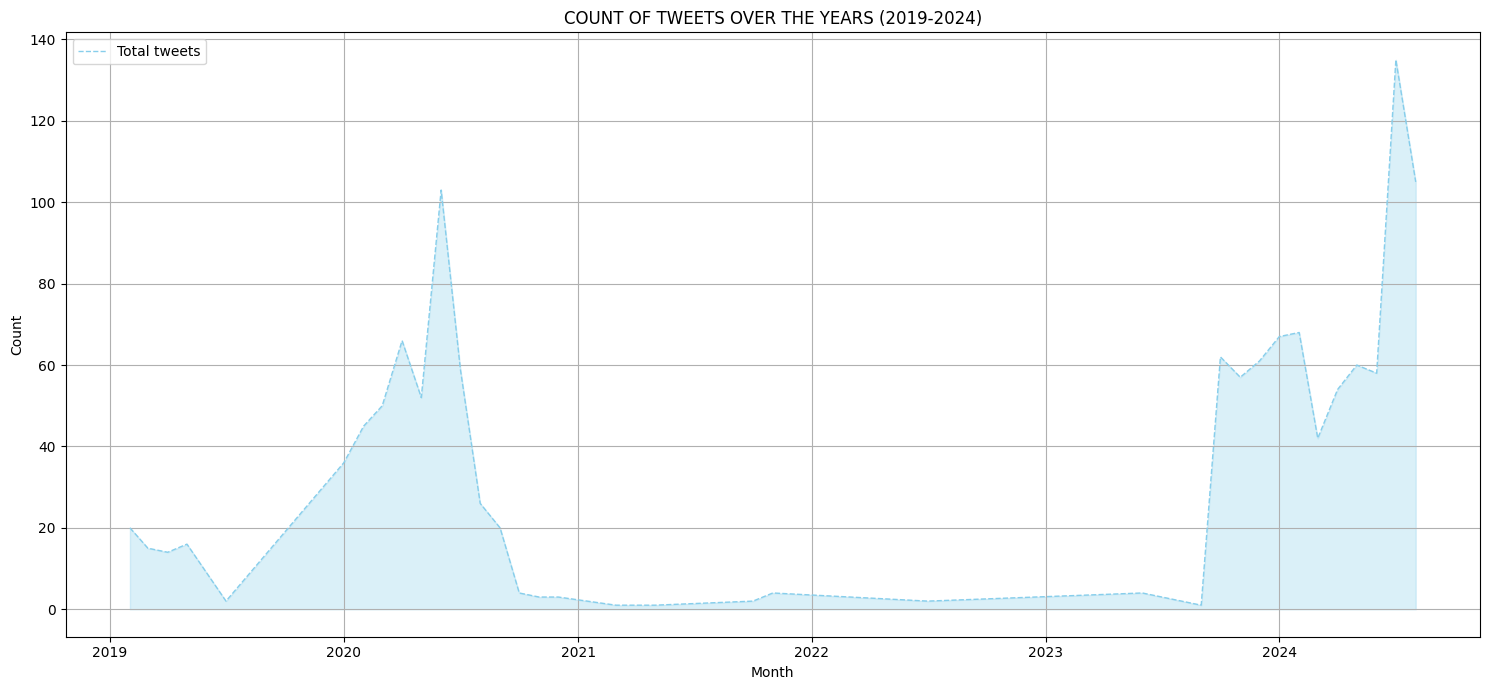

In [87]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(tweets_by_month.index.to_timestamp(), tweets_by_month['tweet_id'],linewidth=1, color='skyblue', linestyle='--', label='Total tweets')
plt.fill_between(tweets_by_month.index.to_timestamp(), tweets_by_month['tweet_id'], color='skyblue', alpha=0.3)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('COUNT OF TWEETS OVER THE YEARS (2019-2024)')

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

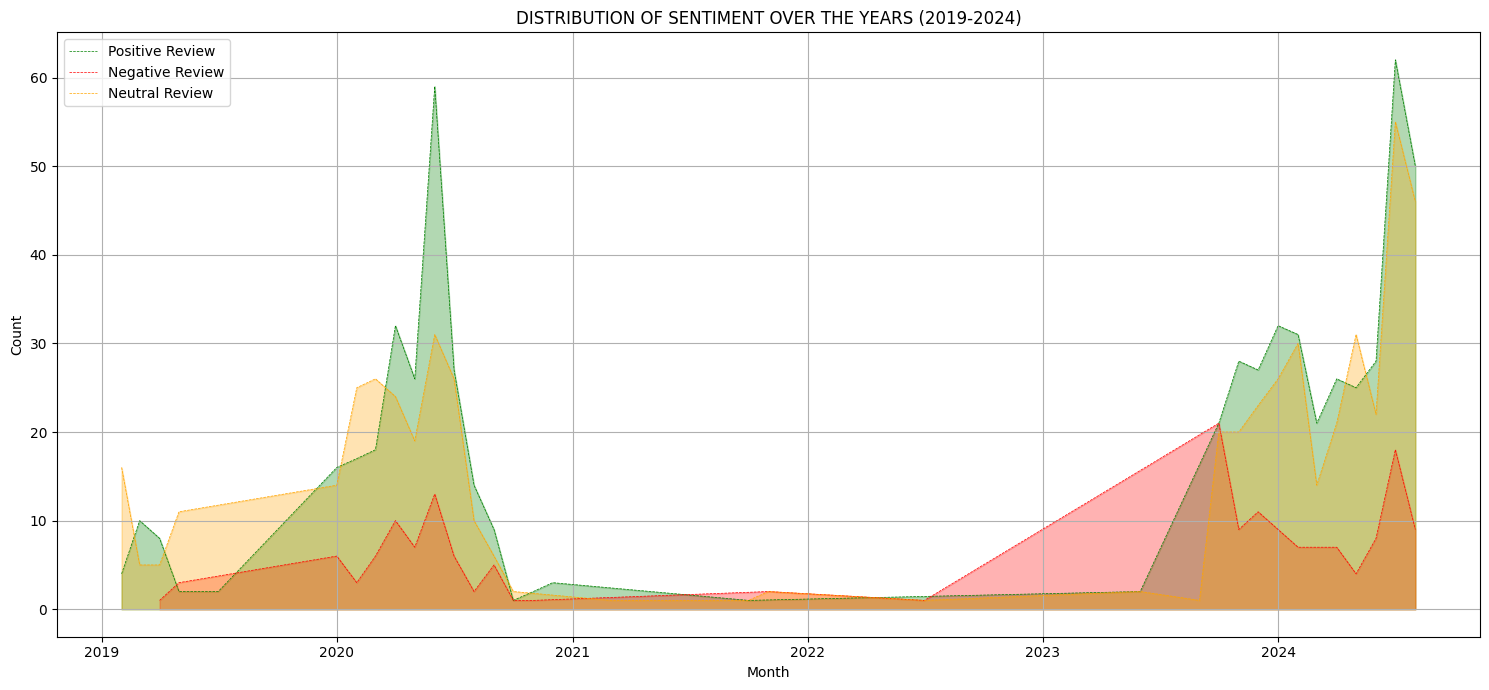

In [88]:
fig, ax = plt.subplots(figsize=(15, 7))

# Plot positive tweets line
plt.plot(positive_tweets_by_month.index.to_timestamp(), positive_tweets_by_month['tweet_id'], linestyle='--',linewidth=0.5, color='green', label='Positive Review')
plt.fill_between(positive_tweets_by_month.index.to_timestamp(), positive_tweets_by_month['tweet_id'], color='green', alpha=0.3)

# Plot negative tweets line
plt.plot(negative_tweets_by_month.index.to_timestamp(), negative_tweets_by_month['tweet_id'], linestyle='--',linewidth=0.5, color='red', label='Negative Review')
plt.fill_between(negative_tweets_by_month.index.to_timestamp(), negative_tweets_by_month['tweet_id'], color='red', alpha=0.3)

# Plot neutral tweets line
plt.plot(neutral_tweets_by_month.index.to_timestamp(), neutral_tweets_by_month['tweet_id'], linestyle='--',linewidth=0.5, color='orange', label='Neutral Review')
plt.fill_between(neutral_tweets_by_month.index.to_timestamp(), neutral_tweets_by_month['tweet_id'], color='orange', alpha=0.3)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('DISTRIBUTION OF SENTIMENT OVER THE YEARS (2019-2024)')

plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

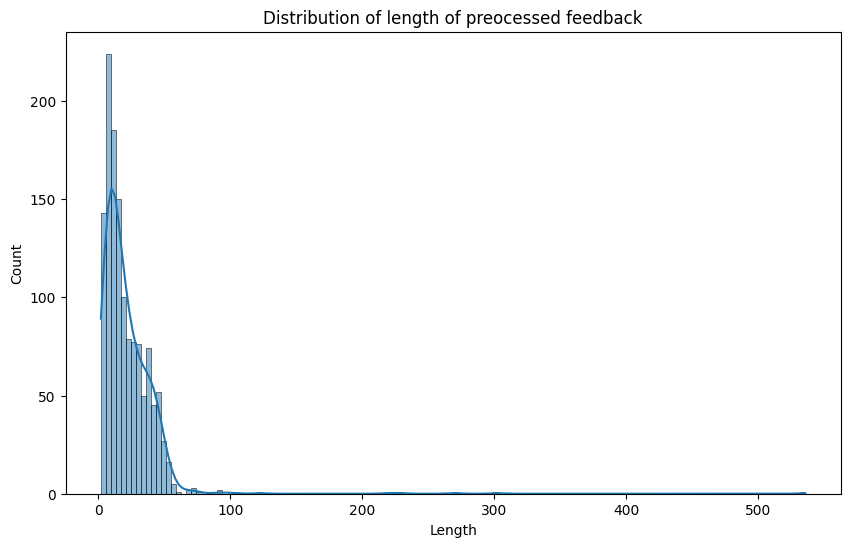

In [28]:
# Distribution of length of preocessed feedback
plt.figure(figsize=(10, 6))
sns.histplot(data['wordcount'], kde = True, palette = 'hls')
plt.title('Distribution of length of preocessed feedback')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

<AxesSubplot:>

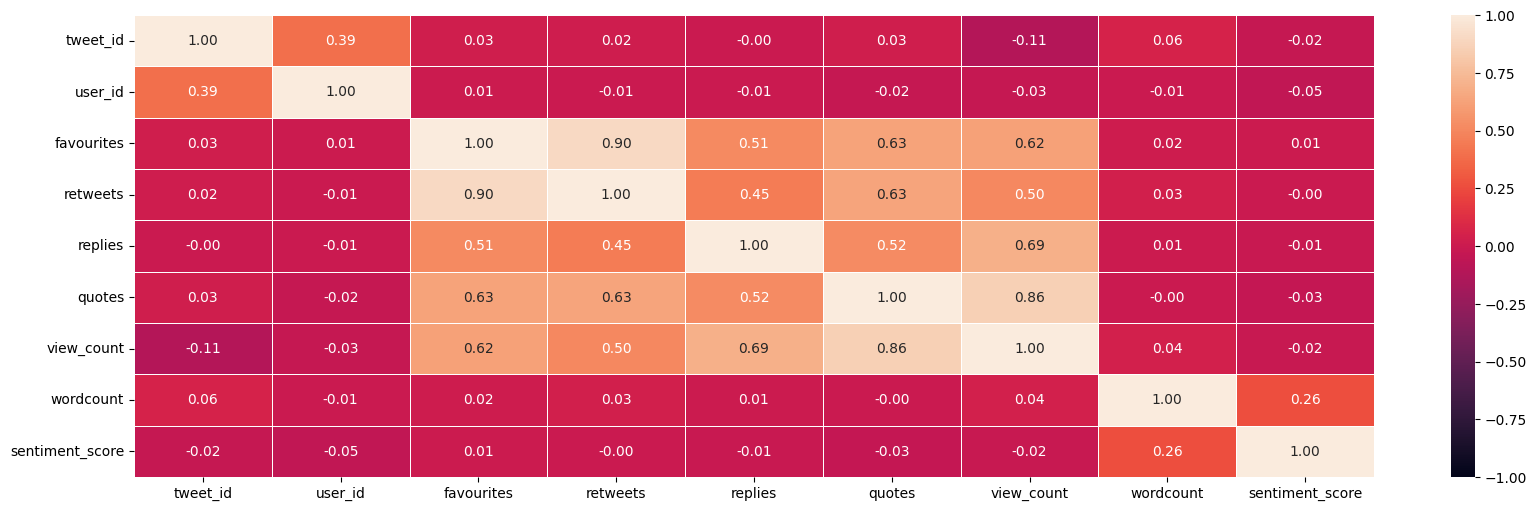

In [90]:
correlation_matrix = data.corr()

plt.figure(figsize=[20, 6])
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1, linewidths=0.5)

The file is saved into the `/data/processed/users_tweet/` folder

In [92]:

csv_file_path = '../data/processed/users_tweet/data_vader.csv'

# Save the DataFrame to the CSV file in the users_tweet folder
data.to_csv(csv_file_path, index=False)

### **CONCLUSION**

This notebook is designed to extract and analyze the sentiment expressed in tweets about PiggyVest using Natural Language Processing (NLP) techniques. The analysis is carried out using NLTK's inbuilt VADER model, which is well-suited for processing and interpreting sentiments in social media texts. The notebook is organized into the following key sections:

Data Import and Initial Inspection: This section involves fetching raw tweet data from a Snowflake data warehouse. The data is then converted into a pandas DataFrame for ease of manipulation. Initial inspection of the data includes exploring its structure and content to ensure it is suitable for further analysis.

Data Cleaning and Preprocessing: This phase focuses on preparing the data for sentiment analysis. It includes feature engineering, where new columns may be created to enhance the dataset's utility. Data preprocessing steps involve removing irrelevant elements such as stopwords, punctuation, and special characters to clean the text data. This ensures that the sentiment analysis is based on meaningful and relevant text.

Sentiment Analysis: In this section, sentiment extraction is performed using NLTK’s VADER model. VADER is specifically designed to handle the nuances of social media language. This model classifies each tweet into different sentiment categories, such as positive, neutral, or negative.

Exploratory Data Analysis (EDA): The final section involves performing exploratory data analysis to understand the distribution and patterns of sentiments among Twitter users. EDA provides insights into how sentiments are distributed, identifies trends, and helps in interpreting the overall sentiment landscape related to PiggyVest.

#### **`NOTE`**

A new dataset `data_vader.csv` is created and saved in the `../data/processed/users_tweet/` directory. This dataset contains additional 'sentiments', 'sentiment_score', 'date_created' and 'processed_text' columns